# Cardiovascular Disease Prediction

The goal of the project is to analyze Cardiovascular Disease dataset to find which factors are related to the heart diseases.

The dataset consists of `70 000` records of patients data: `11` features and a target variable.

Input features could be considered as belonging to the following `3` types:

- <u>Objective</u>: factual information;
- <u>Examination</u>: results of medical examination;
- <u>Subjective</u>: information given by the patient.

Features:


| Feature Description                             | Feature Type           | Feature Name  | Data Type                                                    |
|-------------------------------------------------|------------------------|---------------|--------------------------------------------------------------|
| `Age`                                           | Objective Feature      | `age`         | int (days)                                                   |
| `Height`                                        | Objective Feature      | `height`      | int (cm)                                                     |
| `Weight`                                        | Objective Feature      | `weight`      | float (kg)                                                   |
| `Gender`                                        | Objective Feature      | `gender`      | Categorical code                                             |
| `Systolic blood pressure`                       | Examination Feature    | `ap_hi`       | int                                                          |
| `Diastolic blood pressure`                      | Examination Feature    | `ap_lo`       | int                                                          |
| `Cholesterol`                                   | Examination Feature    | `cholesterol` | `1`: `normal`, `2`: `above normal`, `3`: `well above normal` |
| `Glucose`                                       | Examination Feature    | `gluc`        | `1`: `normal`, `2`: `above normal`, `3`: `well above normal` |
| `Smoking`                                       | Subjective Feature     | `smoke`       | binary                                                       |
| `Alcohol intake`                                | Subjective Feature     | `alco`        | binary                                                       |
| `Physical activity`                             | Subjective Feature     | `active`      | binary                                                       |
| `Presence or absence of cardiovascular disease` | <u>Target Variable</u> | `cardio`      | binary                                                       |


All of the dataset values were collected at the moment of medical examination.

# 0. Preparation

Installing libraries that might be missing:

In [1]:
!pip install numpy pandas seaborn matplotlib scikit-learn lightgbm eli5

Importing required Python modules:

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, PrecisionRecallDisplay
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.utils.class_weight import compute_class_weight

from scipy.stats import loguniform

from lightgbm import LGBMClassifier
import eli5
from eli5.sklearn import PermutationImportance

import lightgbm as lgb
from catboost import CatBoostClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import Dataset, DataLoader

RANDOM_STATE = 12345

Loading dataset into a dataframe and briefly looking at the header, dataset information and distributions information:

In [3]:
data = pd.read_csv('yap7-heart-diseases-prediction/train.csv')
data_kaggle = pd.read_csv('yap7-heart-diseases-prediction/test.csv')
kaggle_ids = data_kaggle['id']

display(data.head())
display(data.info())
display(data.describe())

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


None

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


# 1. Data Preparation

Dividing values of `age` by `365` to represent values in years, not in days:

In [4]:
data['age'] = data['age'] / 365.
data_kaggle['age'] = data_kaggle['age'] / 365.

Removing `id` column as we won't need it anymore:

In [5]:
data = data.drop('id', axis=1)
data_kaggle = data_kaggle.drop('id', axis=1)

data.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1


Columns `smoke`, `alco` and `active` represent binary (yes/no) information, so we'll rename these columns by prepending `is_` prefix to each of the column names:

In [6]:
renaming_dict = {'smoke': 'is_smoking', 'alco': 'is_alco', 'active': 'is_active'}
data = data.rename(columns=renaming_dict)
data_kaggle = data_kaggle.rename(columns=renaming_dict)

data.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoking,is_alco,is_active,cardio
0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0


## 1.1 Missing values analysis

Let's figure out if there are missing values in the dataset:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  float64
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   is_smoking   70000 non-null  int64  
 9   is_alco      70000 non-null  int64  
 10  is_active    70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(2), int64(10)
memory usage: 6.4 MB


Accoring to the output above, there are no missing (N/A) values in the dataset, all columns contain exactly `70000` values.

## 1.2 Duplicates analysis


In [8]:
def print_duplicates_info():
    print(f'Number of duplicates in dataset: {data.duplicated().sum()}')
    print(f'Shape of dataset: {data.shape}')
    
print_duplicates_info()

Number of duplicates in dataset: 24
Shape of dataset: (70000, 12)


Removing `24` duplicated observations and checking there are no more identical rows anymore:

In [9]:
data = data.drop_duplicates()
print_duplicates_info()

Number of duplicates in dataset: 0
Shape of dataset: (69976, 12)


# 2. Exploratory Data Analysis

Looking at the `describe()` output hoping to get information about possible outliers:

In [10]:
data.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,is_smoking,is_alco,is_active,cardio
count,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000,69976.000000
mean,53.339589,1.349648,164.359152,74.208519,128.820453,96.636261,1.366997,1.226535,0.088159,0.053790,0.803718,0.499771
std,6.759930,0.476862,8.211218,14.397211,154.037729,188.504581,0.680333,0.572353,0.283528,0.225604,0.397187,0.500004
min,29.583562,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.394521,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.980822,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.430137,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.967123,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Some insights that we might observe:

- `age` has a minimum value of `29.5` years, that is possibly an outlier (since mean value of `53.33` is slightly less than a median valus of `53.98`);
- `height` looks suspicious in terms of both the minimum (`55` cm) and the maximum (`250` cm), these do look like outliers;
- `weight` as well has strange minimum and maximum values (`10` kg  and `200` kg accordingly);
- `ap_hi` is definitely having problematic values - minimum value is negative (`-150`) and the maximum is incredibly high — `16020`;
- `ap_lo` has similar issues: the minimum is `-70` and the maximum is `11000`.

Remaining factors such as `cholesterol`, `gluc` do not differentiate so much, so they could by analyzed on histogram plots.

## 2.1 Outliers Removal

Removal of outliers will affect messy blood pressure values:

In [11]:
def remove_ap_outliers(df):
    df = df.drop(df[df['ap_hi'] > 310].index)
    df = df.drop(df[df['ap_hi'] < 50].index)

    df = df.drop(df[df['ap_lo'] > 220].index)
    df = df.drop(df[df['ap_lo'] < 30].index)
    return df

def remove_all_outliers(df, print_statistics=False):
    df = df.drop(df[df['ap_hi'] > 250].index)
    df = df.drop(df[df['ap_hi'] < 70].index)

    df = df.drop(df[df['ap_lo'] > 200].index)
    df = df.drop(df[df['ap_lo'] < 45].index)

    df = df.drop(df[df['weight'] > 200].index)
    df = df.drop(df[df['weight'] < 50].index)

    df = df.drop(df[df['height'] > 210].index)
    df = df.drop(df[df['height'] < 120].index)
    return df

## 2.2 Correcting Blood Pressure Values

### 2.2.1 Correcting by swapping and 10-s division/multiplication

Defining functions that would be used later on:

In [12]:
def multiply_by_ten(ap):
    if ap == 0:
        return ap
    while ap < 30:
        ap *= 10
    return ap

def divide_by_ten(ap):
    if ap == 0:
        return ap
    while ap > 300:
        ap /= 10
    return ap

def swap_ap(row):
    row['ap_hi'], row['ap_lo'] = row['ap_lo'], row['ap_hi']
    return row

def correct_swapped_ap(df, print_debug=False):
    swapped_ap_index = df[df['ap_hi'] < df['ap_lo']].index
    if print_debug:
        display(df.loc[swapped_ap_index])
    df.loc[swapped_ap_index, :] = df.loc[swapped_ap_index, :].apply(swap_ap, axis=1)
    if print_debug:
        display(df.loc[swapped_ap_index])

def make_ap_positive(df):
    ap_lo_negatives_index = df[df['ap_lo'] < 0].index
    ap_hi_negatives_index = df[df['ap_hi'] < 0].index

    df.loc[ap_lo_negatives_index, 'ap_lo'] *= -1
    df.loc[ap_hi_negatives_index, 'ap_hi'] *= -1

def correct_ap_lo(df, print_debug=False):
    oob_small_index = df[df['ap_lo'] < 30].index
    oob_large_index = df[df['ap_lo'] > 220].index

    if print_debug:
        display(df.loc[oob_small_index].head(5))
    df.loc[oob_small_index, 'ap_lo'] = df.loc[oob_small_index, 'ap_lo'].apply(lambda ap: multiply_by_ten(ap))
    df.loc[oob_large_index, 'ap_lo'] = df.loc[oob_large_index, 'ap_lo'].apply(lambda ap: divide_by_ten(ap))
    if print_debug:
        display(df.loc[oob_small_index].head(5))

def correct_ap_hi(df, print_debug=False):
    oob_small_index = df[df['ap_hi'] < 50].index
    oob_large_index = df[df['ap_hi'] > 300].index

    if print_debug:
        display(df.loc[oob_small_index].head(5))
    df.loc[oob_small_index, 'ap_hi'] = df.loc[oob_small_index, 'ap_hi'].apply(lambda ap: multiply_by_ten(ap))
    df.loc[oob_large_index, 'ap_hi'] = df.loc[oob_large_index, 'ap_hi'].apply(lambda ap: divide_by_ten(ap))
    if print_debug:
        display(df.loc[oob_small_index].head(5))

## 2.3 Plotting distributions

Creating a helper function to set plot title and axis labels:

In [13]:
def set_labels_and_grid(ax, category_en, category_ru):
    _ = ax.set_title(f'Plot for feature "{category_en}"')
    _ = ax.set_xlabel(f'{category_ru} ({category_en})')
    _ = ax.set_ylabel('Count')
    _ = ax.grid()
    return ax

### Feature `age`

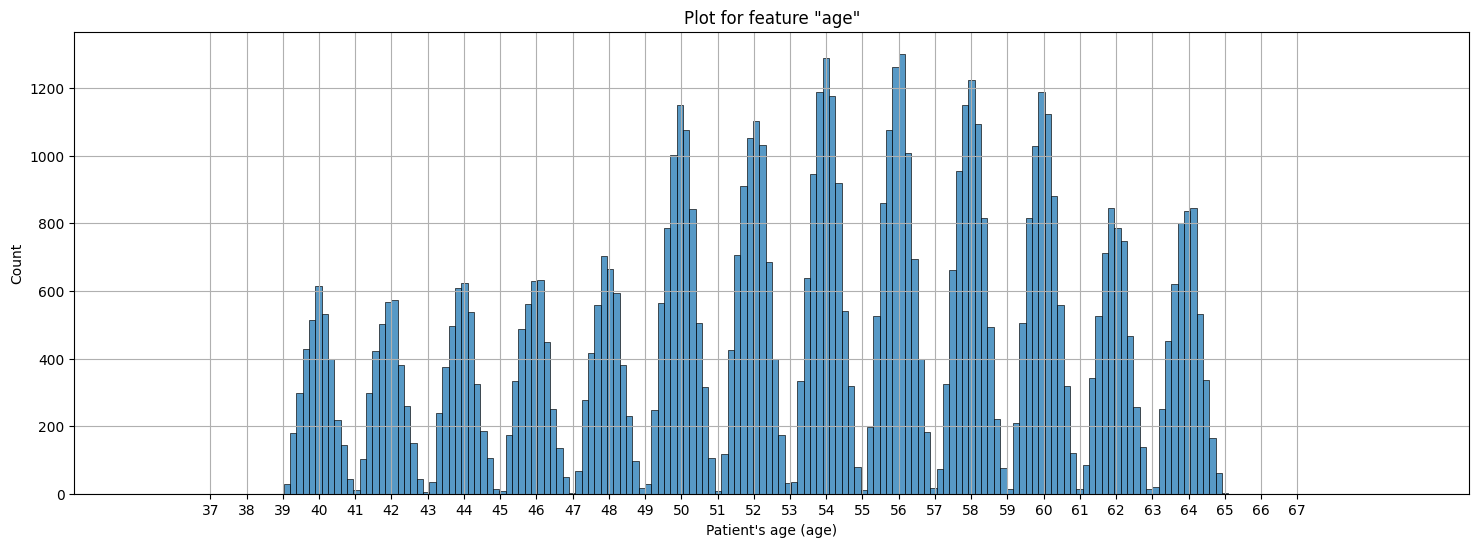

In [14]:
fix, ax = plt.subplots(figsize=(18, 6))
_ = sns.histplot(x='age', data=data, bins=200, binrange=(35, 70))
_ = ax.set_xticks(range(37, 68, 1))
_ = set_labels_and_grid(ax, 'age', "Patient's age")

Such _wavy_ shape of the histogram could sing that medical diagnostics taked place every 2 years starting from patient's age of `40` (for people of age of `40` , of age of `42` etc.).

Now let's separately take a look at patients with and withoud a CVDs:

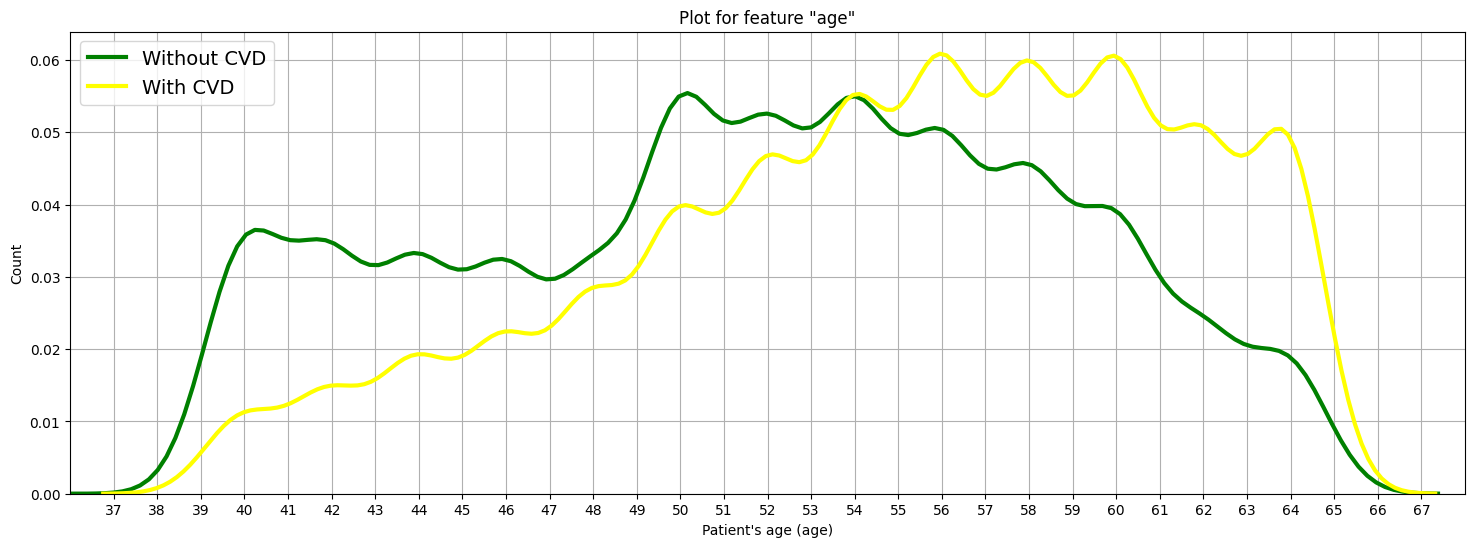

In [15]:
fig, ax = plt.subplots(figsize=(18, 6))
_ = sns.kdeplot(x='age', data=data[data['cardio'] == 0], color='green', linewidth = 3, ax=ax)
_ = sns.kdeplot(x='age', data=data[data['cardio'] == 1], color='yellow', linewidth = 3, ax=ax)
_ = set_labels_and_grid(ax, 'age', "Patient's age")
_ = ax.legend(['Without CVD', 'With CVD'], loc='upper left', prop={'size': 14})
_ = ax.set_xticks(range(37, 68))
_ = ax.set_xlim((36, 68))

It could be observed that disttribution of the patients with CVDs if shifted to the right, and the age of `54` could be considered as a kind of a threshold: after reaching `54` years the number of patients of some particular age <u>with CVD</u> becomes <u>greater</u> than the number of patients of the same age and <u>without CVD</u>.

Therefore the `age` feature is definitely useful and should help the model make correct prediction.

### Feature `gender`

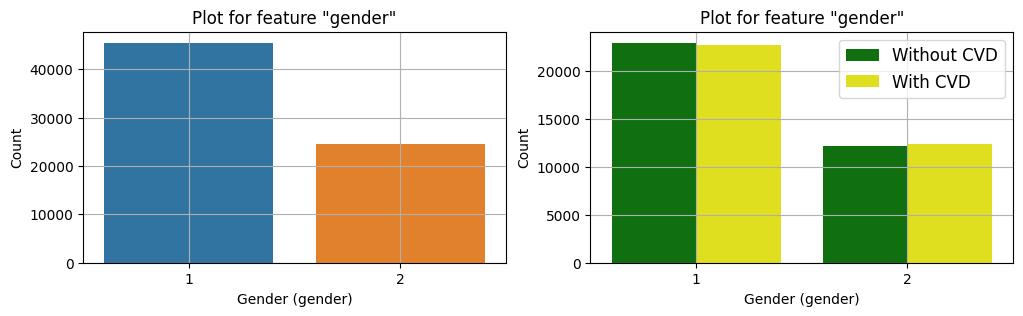

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
_ = sns.countplot(x='gender', data=data, ax=axes[0])
set_labels_and_grid(axes[0], 'gender', 'Gender')
_ = sns.countplot(x='gender', data=data, hue=data['cardio'], palette=["green", "yellow"], ax=axes[1])
set_labels_and_grid(axes[1], 'gender', 'Gender')
_ = axes[1].legend(['Without CVD', 'With CVD'], loc='best', prop={'size': 12})

As it could be seen from countplots above, patients with gender equal to `1` is 2 times as many as patients with gender `2`.

To figure out what values `1` and `2` mean in terms of male/female gender, let's analyze the median heights and weights of patiens from the group with gender `1` and from the group with gender `2`:

In [17]:
data.groupby('gender').agg({'height': 'median', 'weight': 'median'})

,height,weight
gender,,
1,161.0,70.0
2,170.0,75.0


Looking at the table above, we might conclude that value `1` belongs to the `female` gender (median height and weight are smaller), while value `2` belongs to the `male` gender.

Therefore, there are twice as many female patiens in our dataset than male patients.

Finally, looking at the countplot on the right, we might conclude that `gender` is probably not an informative feature: green and yellow columns are of the same height for each of the gender values, `1` and `2`.

### Feature `height`

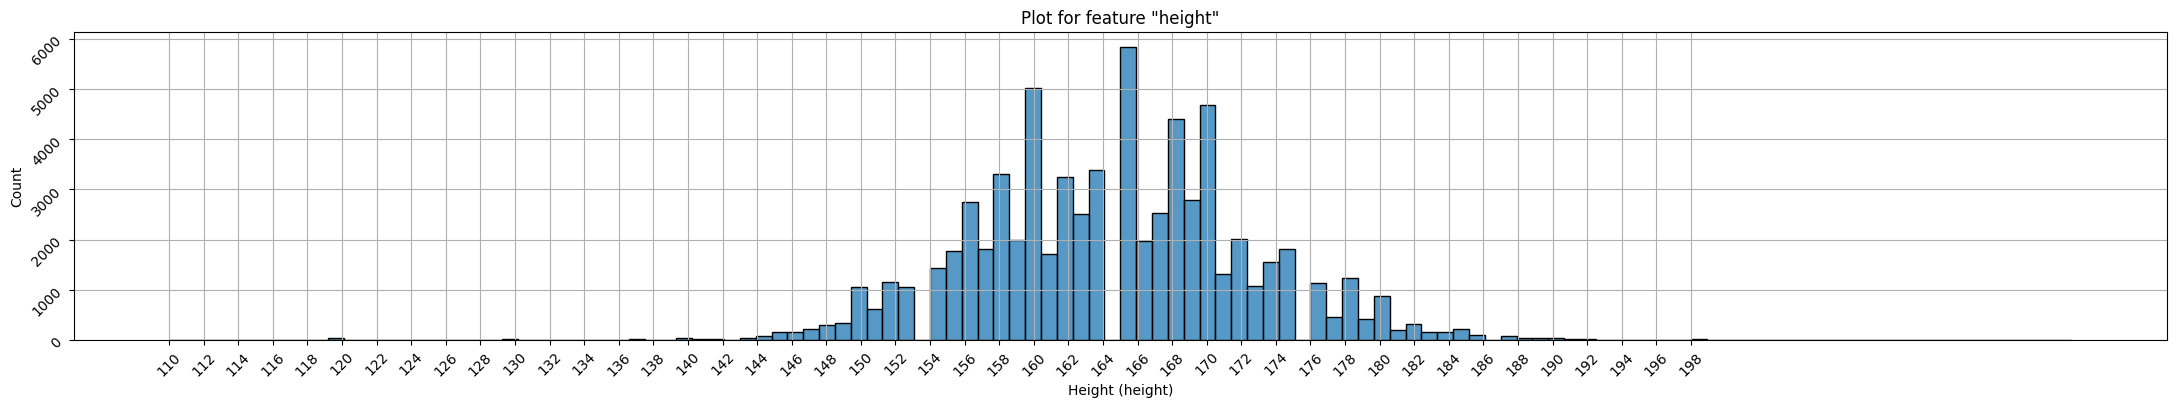

In [18]:
fix, ax = plt.subplots(figsize=(27, 4))
_ = sns.histplot(x='height', data=data, bins=120, binrange=(110, 220))
_ = ax.set_xticks(range(110, 200, 2))
_ = ax.tick_params(labelrotation=45)
_ = set_labels_and_grid(ax, 'height', 'Height')

The distribution's shape look normal, but not smooth. Most of the values are located between `140` and `190` cm, and all values outside that interval could possible be treated as outliers.

Now trying to figure out how separate distributions of CVD patients and non-CVD patients look like in terms of `height` feature:

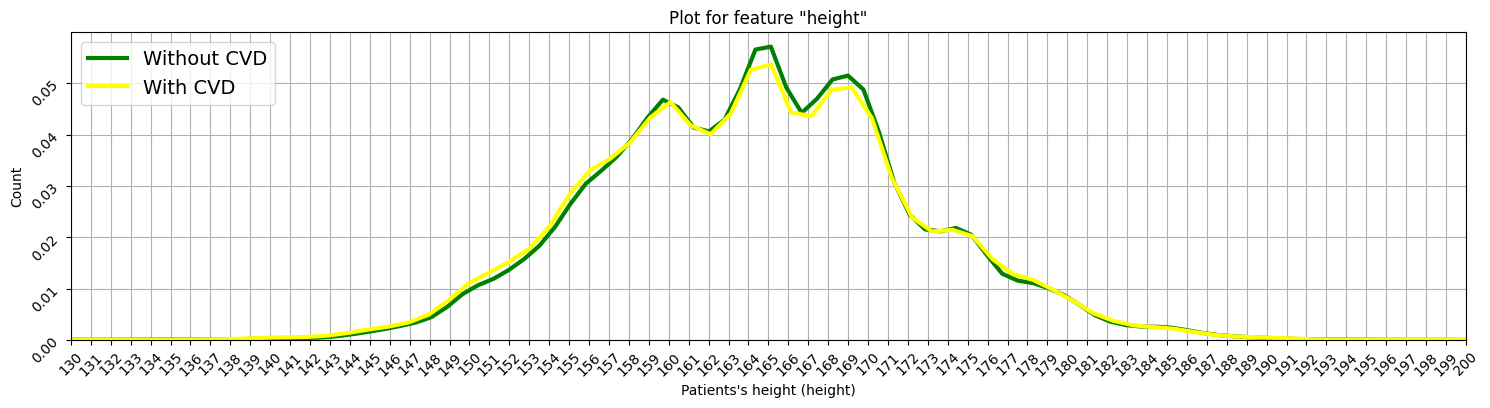

In [19]:
fig, ax = plt.subplots(figsize=(18, 4))
_ = sns.kdeplot(x='height', data=data[data['cardio'] == 0], color='green', linewidth = 3, ax=ax)
_ = sns.kdeplot(x='height', data=data[data['cardio'] == 1], color='yellow', linewidth = 3, ax=ax)
_ = set_labels_and_grid(ax, 'height', "Patients's height")
_ = ax.legend(['Without CVD', 'With CVD'], loc='upper left', prop={'size': 14})
_ = ax.set_xticks(range(50, 225))
_ = ax.tick_params(labelrotation=45)
_ = ax.set_xlim((130, 200))

The plot looks interesting, especially that overlaying effect: how green and yellow curves almost completely overlap.

Such observations leads to the conclusion that `height` (separately) looks unuseful and could barely help the model to make correct predictions.

### Feature `weight`

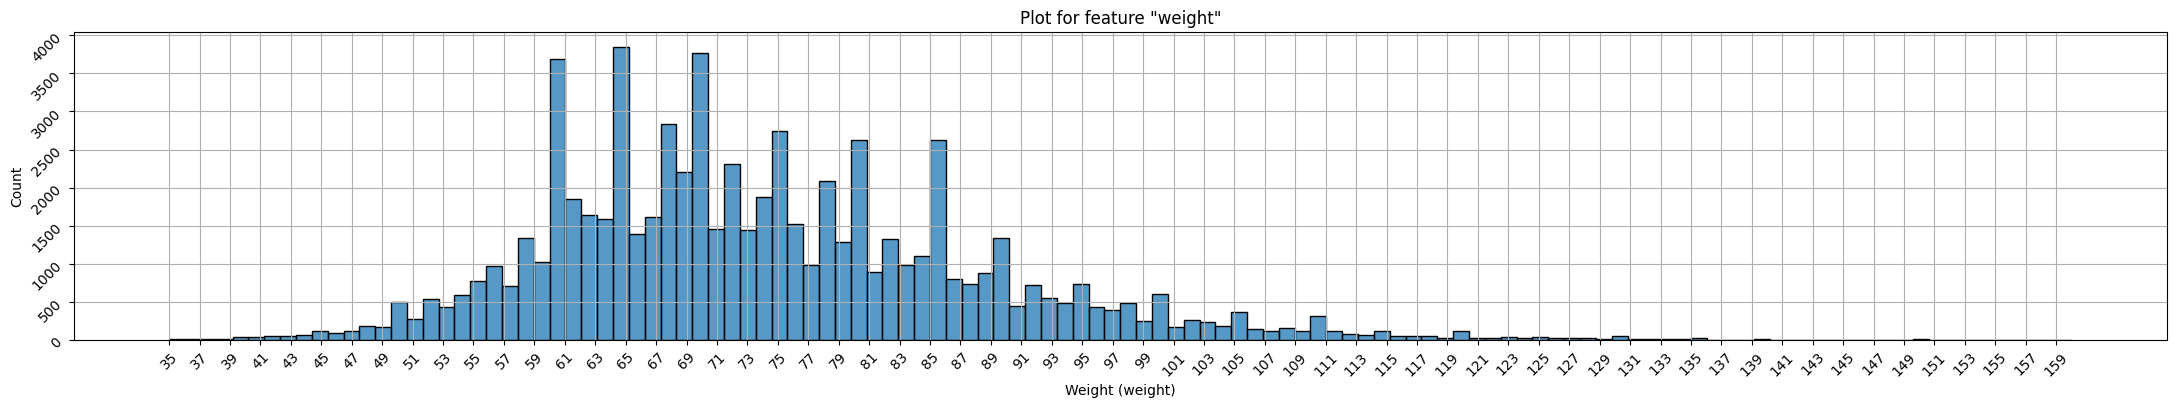

In [20]:
fix, ax = plt.subplots(figsize=(27, 4))
_ = sns.histplot(x='weight', data=data, bins=120, binrange=(35, 160))
_ = ax.set_xticks(range(35, 160, 2))
_ = ax.tick_params(labelrotation=45)
_ = set_labels_and_grid(ax, 'weight', 'Weight')

That distribution also looks normal, but several rises and recession could be observed as well as `3` modes, and the fact that the distribution is skewed to the right.

As usual, plotting also distribution curves for CVD and non-CVD patients:

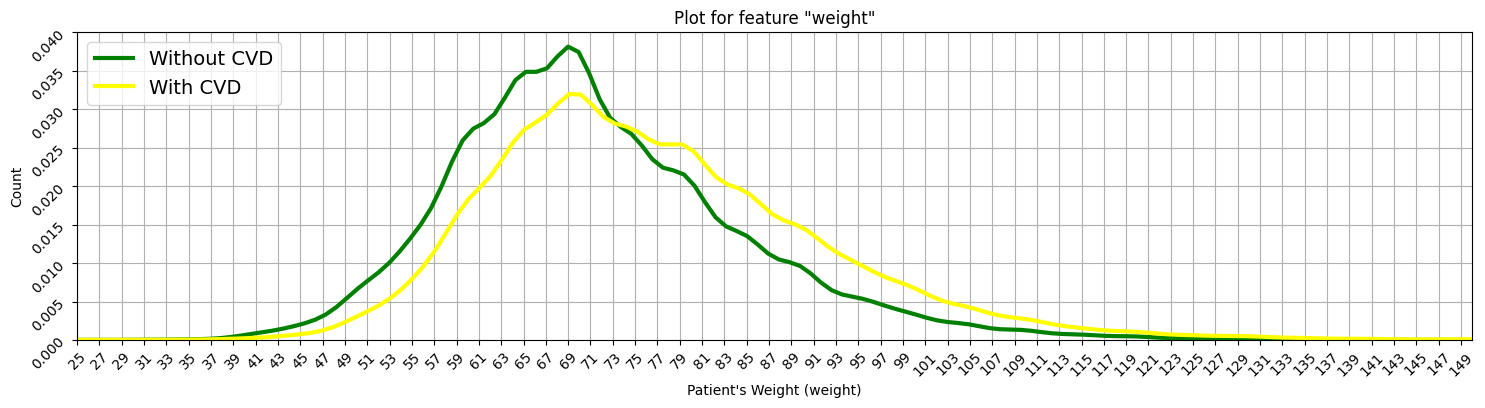

In [21]:
fig, ax = plt.subplots(figsize=(18, 4))
_ = sns.kdeplot(x='weight', data=data[data['cardio'] == 0], color='green', linewidth = 3, ax=ax)
_ = sns.kdeplot(x='weight', data=data[data['cardio'] == 1], color='yellow', linewidth = 3, ax=ax)
_ = set_labels_and_grid(ax, 'weight', "Patient's Weight")
_ = ax.legend(['Without CVD', 'With CVD'], loc='upper left', prop={'size': 14})
_ = ax.set_xticks(range(25, 150, 2))
_ = ax.tick_params(labelrotation=45)
_ = ax.set_xlim((25, 150))

It is not a surprise that distribution of CVD patients is shifted to the right: excess weight negatively affects the cardiovascular system. Around `74` kg number of patients with CVD is constantly greater than the number of patients without CVD.

Therefore, `weight` feature looks useful for the model that we're going t create.

### Feature `ap_hi`

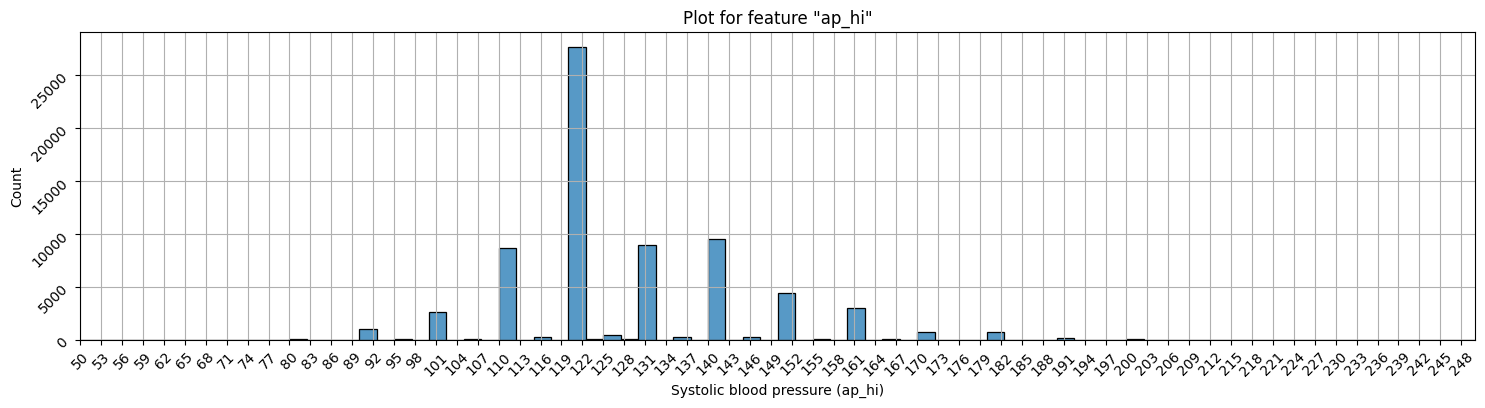

In [22]:
fix, ax = plt.subplots(figsize=(18, 4))
_ = sns.histplot(x='ap_hi', data=data, bins=100, binrange=(0, 250))
_ = ax.set_xticks(range(50, 250, 3))
_ = ax.tick_params(labelrotation=45)
_ = ax.set_xlim((50, 250))
_ = set_labels_and_grid(ax, 'ap_hi', 'Systolic blood pressure')

The distribution is looking more like a descrete, not a continuous one. A distribution mode cound be observed around `120`, as well as the values significantly greater (around `200`) and significantly less (around `80`).

Plotting distribution curves for CVD and non-CVD patients:

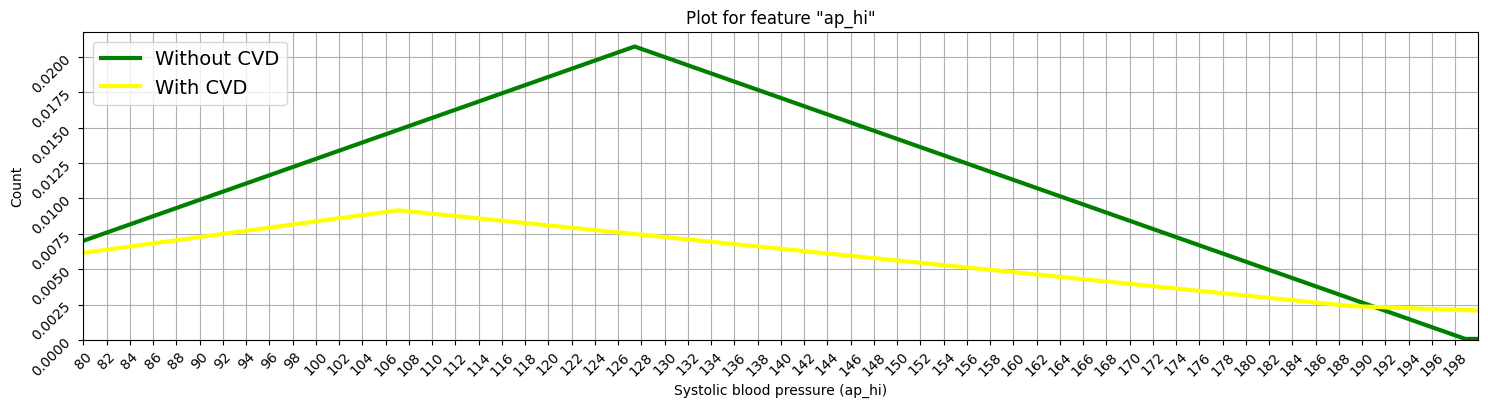

In [23]:
fig, ax = plt.subplots(figsize=(18, 4))
_ = sns.kdeplot(x='ap_hi', data=data[data['cardio'] == 0], color='green', linewidth = 3, ax=ax)
_ = sns.kdeplot(x='ap_hi', data=data[data['cardio'] == 1], color='yellow', linewidth = 3, ax=ax)
_ = set_labels_and_grid(ax, 'ap_hi', 'Systolic blood pressure')
_ = ax.legend(['Without CVD', 'With CVD'], loc='upper left', prop={'size': 14})
_ = ax.set_xticks(range(80, 200, 2))
_ = ax.tick_params(labelrotation=45)
_ = ax.set_xlim((80, 200))

We might see that the value `128` looks like a threshold: starting from that value the number of proportion of patients without a CVD dicreases.

The feature `ap_hi` seems to be a meaningful one.

### Feature `ap_lo`

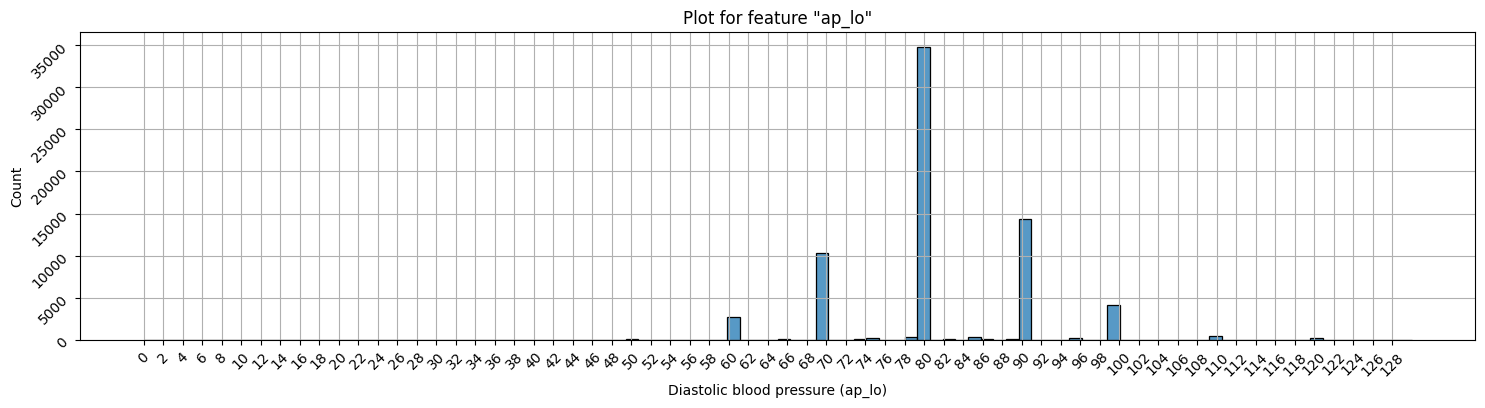

In [24]:
fix, ax = plt.subplots(figsize=(18, 4))
_ = sns.histplot(x='ap_lo', data=data, bins=100, binrange=(0, 130))
_ = ax.set_xticks(range(0, 130, 2))
_ = ax.tick_params(labelrotation=45)
_ = set_labels_and_grid(ax, 'ap_lo', 'Diastolic blood pressure')

Situation here looks similar to the situaton with `ap_hi` feature. Distribution mode could be observed around `80` and an outlier-looking value around `120`.

As before, plotting CVD and non-CVD distribution in terms of `ap_lo` feature:

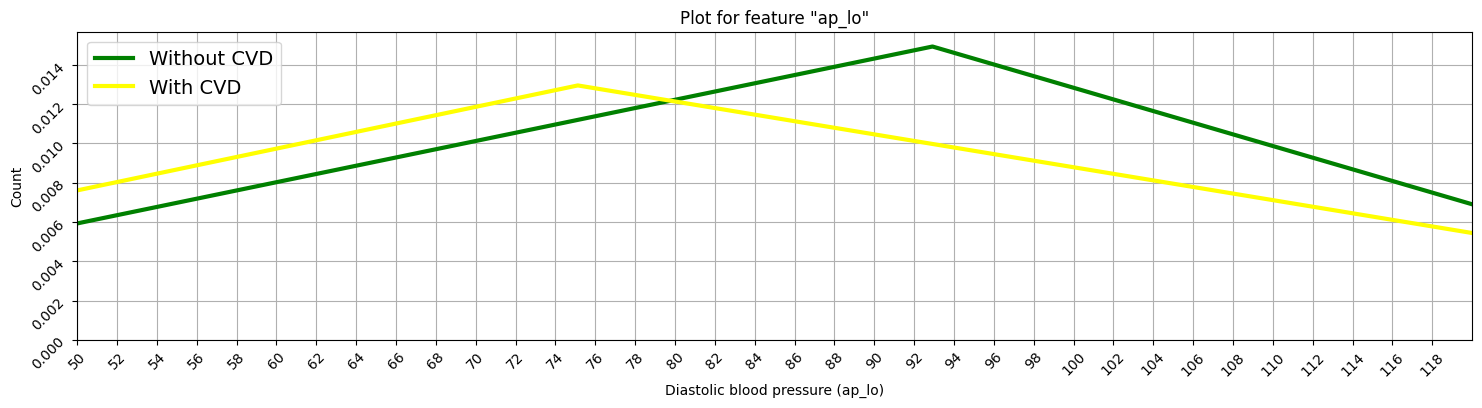

In [25]:
fig, ax = plt.subplots(figsize=(18, 4))
_ = sns.kdeplot(x='ap_lo', data=data[data['cardio'] == 0], color='green', linewidth = 3, ax=ax)
_ = sns.kdeplot(x='ap_lo', data=data[data['cardio'] == 1], color='yellow', linewidth = 3, ax=ax)
_ = set_labels_and_grid(ax, 'ap_lo', 'Diastolic blood pressure')
_ = ax.legend(['Without CVD', 'With CVD'], loc='upper left', prop={'size': 14})
_ = ax.set_xticks(range(50, 120, 2))
_ = ax.tick_params(labelrotation=45)
_ = ax.set_xlim((50, 120))

Green (non-CVD) curve looks shifted to the right — feature `ap_lo` looks promising for predictions model.

### Feature `cholesterol`

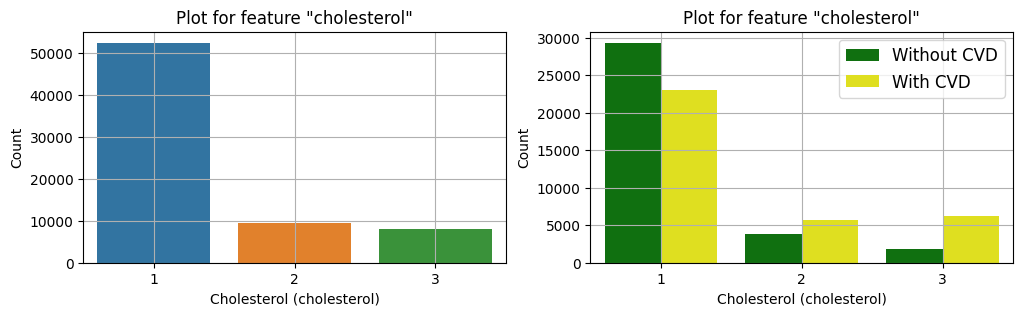

In [26]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
_ = sns.countplot(x='cholesterol', data=data, ax=axes[0])
set_labels_and_grid(axes[0], 'cholesterol', 'Cholesterol')
_ = sns.countplot(x='cholesterol', data=data, hue=data['cardio'], palette=["green", "yellow"], ax=axes[1])
set_labels_and_grid(axes[1], 'cholesterol', 'Cholesterol')
_ = axes[1].legend(['Without CVD', 'With CVD'], loc='best', prop={'size': 12})

The cholesterol feature has only `3` possible values, and that looks slightly unexpected. On the right plot it could be observed that as cholesterol increases (values `2` and `3`), number of patients with CVD increases as well. With cholesterol value equal `3`, CVD-patients number increases significantly.

Feature `cholesterol` looks informative and should be usefaul.

### Feature `gluc`

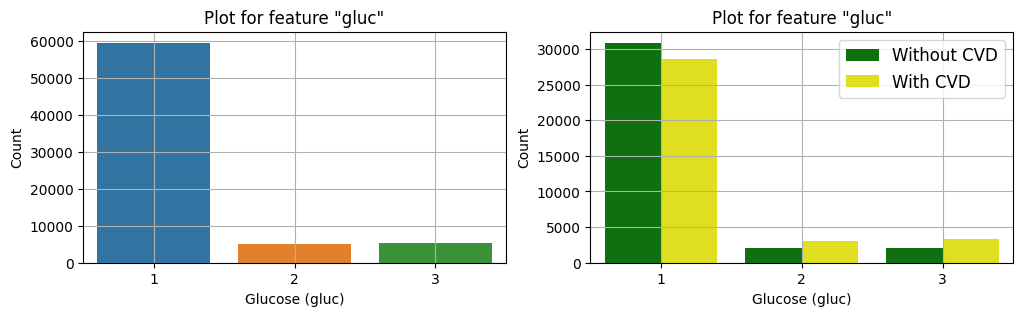

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
_ = sns.countplot(x='gluc', data=data, ax=axes[0])
set_labels_and_grid(axes[0], 'gluc', 'Glucose')
_ = sns.countplot(x='gluc', data=data, hue=data['cardio'], palette=["green", "yellow"], ax=axes[1])
set_labels_and_grid(axes[1], 'gluc', 'Glucose')
_ = axes[1].legend(['Without CVD', 'With CVD'], loc='best', prop={'size': 12})

Glucose values are also represented with `3` possible values only, and the value `1` is significantly dominating. Right plot shows that increase of glucose (values `2` and `3`) leads to the increase of CVD patients as well, while that effect is not so string as it is in case of `cholesterol` feature.

Feature `gluc` looks more informative than useless.

### Feature `is_smoking`

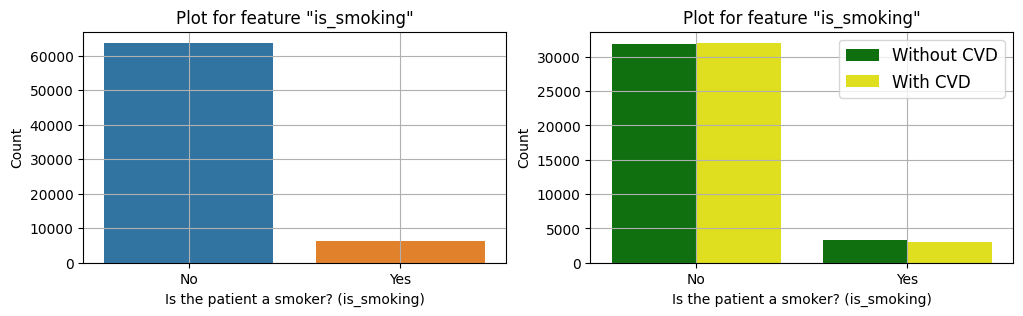

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
_ = sns.countplot(x='is_smoking', data=data, ax=axes[0])
set_labels_and_grid(axes[0], 'is_smoking', 'Is the patient a smoker?')
_ = sns.countplot(x='is_smoking', data=data, hue=data['cardio'], palette=["green", "yellow"], ax=axes[1])
set_labels_and_grid(axes[1], 'is_smoking', 'Is the patient a smoker?')
_ = axes[1].legend(['Without CVD', 'With CVD'], loc='best', prop={'size': 12})
_ = axes[0].set_xticklabels(['No', 'Yes'])
_ = axes[1].set_xticklabels(['No', 'Yes'])

As it might be expected, most of the patients are non-smokers. The fact that proportions of CVD and non-CVD patints are almost equal for smokers and non-smokers looks really unexpected, and because of that it is hard to say for sure if the feature `is_smoking` would be useful for the predictions model or not.

### Feature `is_alco`

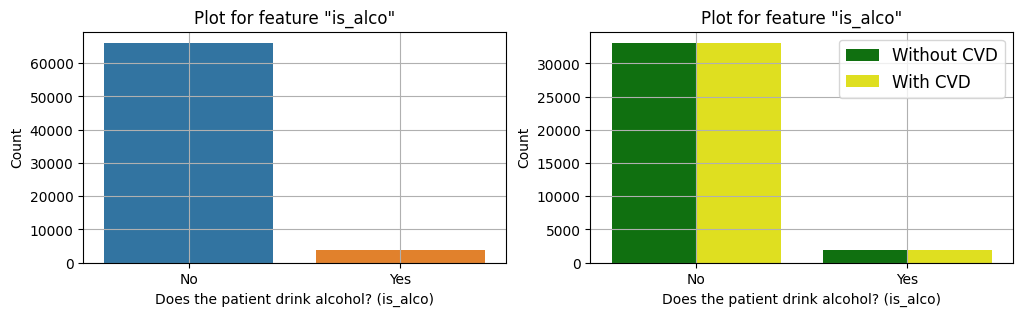

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
_ = sns.countplot(x='is_alco', data=data, ax=axes[0])
set_labels_and_grid(axes[0], 'is_alco', 'Does the patient drink alcohol?')
_ = sns.countplot(x='is_alco', data=data, hue=data['cardio'], palette=["green", "yellow"], ax=axes[1])
set_labels_and_grid(axes[1], 'is_alco', 'Does the patient drink alcohol?')
_ = axes[1].legend(['Without CVD', 'With CVD'], loc='best', prop={'size': 12})
_ = axes[0].set_xticklabels(['No', 'Yes'])
_ = axes[1].set_xticklabels(['No', 'Yes'])

Domination of non-drinking patients looks promising, but (almost) equal sizes of green and yellow proportions leads to doubts regarding usefulness of `is_alco` feature.

### Feature `is_active`

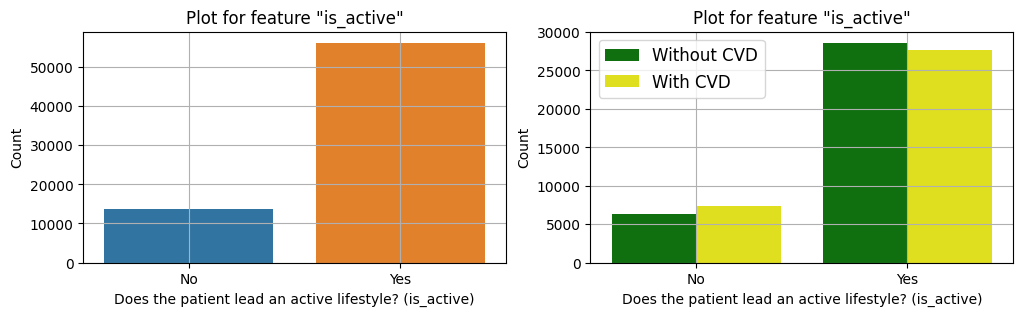

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 3))
_ = sns.countplot(x='is_active', data=data, ax=axes[0])
set_labels_and_grid(axes[0], 'is_active', 'Does the patient lead an active lifestyle?')
_ = sns.countplot(x='is_active', data=data, hue=data['cardio'], palette=["green", "yellow"], ax=axes[1])
set_labels_and_grid(axes[1], 'is_active', 'Does the patient lead an active lifestyle?')
_ = axes[1].legend(['Without CVD', 'With CVD'], loc='best', prop={'size': 12})
_ = axes[0].set_xticklabels(['No', 'Yes'])
_ = axes[1].set_xticklabels(['No', 'Yes'])

The proportion of active patients is much greater than the proportion of non-actives. Right plot shoul a really small domination of CVD for non-active patients, and approximately equally small domination of non-CVD patients among active people.

Taking that into account, we might conclude that the feature `is_active` could still be useful for built ML model.

### Feature `cardio` (target variable)

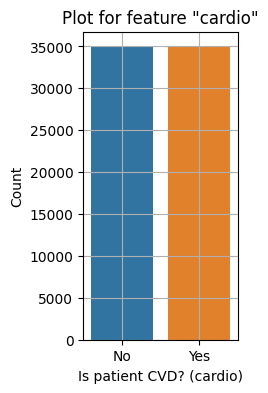

In [31]:
fix, ax = plt.subplots(figsize=(2, 4))
_ = sns.countplot(x='cardio', data=data)
_ = set_labels_and_grid(ax, 'cardio', 'Is patient CVD?')
_ = ax.set_xticklabels(['No', 'Yes'])
_ = ax.set_xticklabels(['No', 'Yes'])

Number of CVD and non-CVD patients are almost equal, so we're dealing with a balanced dataset.

# Train/Test Split

Since we will use cross-validation to find best hyperparameter values, entire dataset would be split onto train and test parts (without validation part).

`25%` of the data will form a test subset:

In [32]:
X = data.drop('cardio', axis=1)
y = data['cardio']

X_kaggle = data_kaggle

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=RANDOM_STATE)

# Feature Engineering

Several new engineered features would bd added, such as:

- Body Mass Index;

- Blood Pressuer Difference;

- Age Group;

- Hypertension Stage.

Defining helper functions to add mentioned features:

## - Body Mass Index

In [33]:
def add_bmi_feature(df):
    df['bmi'] = df['weight'] / ((df['height'] / 100) ** 2)
    bmi_bin_intervals = pd.IntervalIndex.from_tuples([(0, 18.5), (18.5, 24.9), (24.9, 29.9), (29.9, 34.9), (34.9, 39.9), (39.9, 5_000)])

    df['bmi_bin'] = pd.cut(df['bmi'], bmi_bin_intervals)
    df['bmi_category'] = df['bmi_bin'].cat.rename_categories([1, 2, 3, 4, 5, 6])
    df.drop(['bmi_bin'], axis=1, inplace=True)

## - Blood Pressure Difference

In [34]:
def add_ap_diff_feature(df):
    df['ap_diff'] = df['ap_hi'] - df['ap_lo']

## - Age Group

In [35]:
def add_age_group_feature(df):
    age_intervals = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, 45),
                                                  (45, 50), (50, 55), (55, 60), (60, 65), (65, 70), (70, 75), (75, 80)])
    df['age_group'] = pd.cut(df['age'], age_intervals)
    df['age_group'] = df['age_group'].cat.rename_categories([i + 1 for i in range(14)])

## - Hypertension Stage

In [36]:
def set_ap_hi_hypertension_stage(ap_hi):
    if ap_hi < 140:
        return 0
    if 140 <= ap_hi <= 159:
        return 1
    if 160 <= ap_hi <= 170:
        return 2
    return 3

def set_ap_lo_hypertension_stage(ap_lo):
    if ap_lo < 90:
        return 0
    if 90 <= ap_lo <= 99:
        return 1
    if 100 <= ap_lo <= 109:
        return 2
    return 3
    
def add_hypertension_stage_feature(df):
    df['ap_hi_ht_stage'] = df['ap_hi'].apply(set_ap_hi_hypertension_stage)
    df['ap_lo_ht_stage'] = df['ap_lo'].apply(set_ap_lo_hypertension_stage)

Adding new features to the datasets:

In [37]:
def add_new_features(df):
    add_bmi_feature(df)
    add_ap_diff_feature(df)
    add_age_group_feature(df)
    add_hypertension_stage_feature(df)

add_new_features(X_train)
add_new_features(X_test)
add_new_features(X_kaggle)

# Data Preprocessing

Replacing strange value of blood pressure with `NaN`s, so we will be able to use KNN imputation to fill these missing values later on:

In [38]:
def replace_messy_ap_with_nans(df):
    df.loc[df['ap_hi'] > 310, 'ap_hi'] = np.nan
    df.loc[df['ap_hi'] <  50, 'ap_hi'] = np.nan
    
    df.loc[df['ap_lo'] > 220, 'ap_lo'] = np.nan
    df.loc[df['ap_lo'] <  30, 'ap_lo'] = np.nan

replace_messy_ap_with_nans(X_train)
replace_messy_ap_with_nans(X_test)
replace_messy_ap_with_nans(X_kaggle)

Using ColumnTransformer and Pipeline to perform One-Hot Encoding, standartization, imputation and adding of polynomial features:

In [39]:
cat_features = ['gender', 'cholesterol', 'gluc']
num_features = [e for e in X_train.columns if e not in cat_features]

numeric_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')),
                                      ('poly', PolynomialFeatures(degree=1, include_bias=False)),
                                      ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')),
                                          ('onehot', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)])

preprocess_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

X_train = preprocess_pipeline.fit_transform(X_train, y_train)
X_test = preprocess_pipeline.transform(X_test)
X_kaggle = preprocess_pipeline.transform(X_kaggle)

encoded_num_features = preprocess_pipeline['preprocessor'].transformers_[0][1]['poly'].get_feature_names_out(num_features)
encoded_num_features = [x.replace(' ', '_').lower() for x in list(encoded_num_features)]

encoded_cat_features = preprocess_pipeline['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_features)
encoded_cat_features = [x.replace(' ', '_').lower() for x in list(encoded_cat_features)]

feature_names = encoded_num_features + list(encoded_cat_features)

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)
X_kaggle = pd.DataFrame(X_kaggle, columns=feature_names)

print('X_train.head():')
display(X_train.head())

print('X_test.head():')
display(X_test.head())

print('X_kaggle.head():')
display(X_kaggle.head())

X_train.head():


,age,height,weight,ap_hi,ap_lo,is_smoking,is_alco,is_active,bmi,bmi_category,ap_diff,age_group,ap_hi_ht_stage,ap_lo_ht_stage,gender_2.0,cholesterol_2.0,cholesterol_3.0,gluc_2.0,gluc_3.0
0,-0.449021,0.938993,-1.126529,1.888098,0.871429,-0.310836,-0.238115,0.493101,-1.323145,-0.983981,0.157692,-0.115829,2.465697,0.838916,1.0,0.0,0.0,0.0,0.0
1,1.375171,0.816534,1.237639,0.745381,0.871429,-0.310836,-0.238115,0.493101,0.649703,0.954433,0.074927,1.354117,0.957009,0.838916,1.0,1.0,0.0,0.0,0.0
2,0.592795,-0.775434,0.750898,0.745381,-0.142170,-0.310836,-0.238115,-2.027983,1.080021,0.954433,0.116309,0.619144,0.957009,-0.565575,0.0,0.0,0.0,0.0,0.0
3,1.239565,-0.775434,-0.083514,0.174022,-0.142170,-0.310836,-0.238115,0.493101,0.280245,-0.014774,0.074927,1.354117,-0.551679,-0.565575,0.0,0.0,1.0,0.0,1.0
4,1.527018,1.673747,0.820433,-0.397337,-0.142170,3.217128,-0.238115,0.493101,-0.068998,-0.014774,0.033544,1.354117,-0.551679,-0.565575,1.0,0.0,0.0,0.0,0.0


X_test.head():


,age,height,weight,ap_hi,ap_lo,is_smoking,is_alco,is_active,bmi,bmi_category,ap_diff,age_group,ap_hi_ht_stage,ap_lo_ht_stage,gender_2.0,cholesterol_2.0,cholesterol_3.0,gluc_2.0,gluc_3.0
0,0.432422,-0.652975,-1.196063,-0.397337,-0.142170,-0.310836,-0.238115,0.493101,-0.833757,-0.983981,0.033544,0.619144,-0.551679,-0.565575,0.0,0.0,0.0,0.0,0.0
1,0.918413,-0.163139,-0.778857,-0.397337,-1.155769,-0.310836,-0.238115,0.493101,-0.639880,-0.983981,0.074927,0.619144,-0.551679,-0.565575,0.0,1.0,0.0,0.0,0.0
2,-1.465663,-0.530516,-0.848391,-0.397337,-0.142170,-0.310836,-0.238115,0.493101,-0.555541,-0.983981,0.033544,-1.585776,-0.551679,-0.565575,0.0,0.0,0.0,0.0,0.0
3,-1.411664,0.816534,0.611830,0.745381,-2.169369,-0.310836,-0.238115,0.493101,0.137607,-0.014774,0.199074,-1.585776,0.957009,-0.565575,0.0,0.0,0.0,0.0,0.0
4,-0.158319,-1.387730,-1.335132,-0.397337,-1.155769,-0.310836,-0.238115,0.493101,-0.675919,-0.983981,0.074927,-0.115829,-0.551679,-0.565575,0.0,0.0,0.0,0.0,0.0


X_kaggle.head():


,age,height,weight,ap_hi,ap_lo,is_smoking,is_alco,is_active,bmi,bmi_category,ap_diff,age_group,ap_hi_ht_stage,ap_lo_ht_stage,gender_2.0,cholesterol_2.0,cholesterol_3.0,gluc_2.0,gluc_3.0
0,-0.237491,-1.265270,0.750898,0.174022,-0.142170,-0.310836,-0.238115,0.493101,1.378133,1.923640,0.074927,-0.115829,-0.551679,-0.565575,0.0,0.0,0.0,0.0,0.0
1,-0.174965,0.694075,-0.361651,0.174022,0.871429,-0.310836,-0.238115,0.493101,-0.612662,-0.983981,0.033544,-0.115829,-0.551679,0.838916,1.0,0.0,0.0,0.0,0.0
2,0.389385,-0.530516,-0.292117,-0.397337,-0.648970,-0.310836,-0.238115,-2.027983,-0.035603,-0.014774,0.054235,0.619144,-0.551679,-0.565575,0.0,0.0,0.0,0.0,0.0
3,-0.544026,2.530961,1.376708,0.174022,0.871429,-0.310836,-0.238115,0.493101,-0.015379,-0.014774,0.033544,-0.850803,-0.551679,0.838916,1.0,0.0,0.0,0.0,0.0
4,-1.372282,0.694075,0.125089,-0.397337,-0.142170,-0.310836,-0.238115,0.493101,-0.209666,-0.014774,0.033544,-1.585776,-0.551679,-0.565575,1.0,0.0,0.0,0.0,0.0


In [40]:
print(f'X Train: {X_train.shape}  X Test: {X_test.shape}  X Kaggle: {X_kaggle.shape}')
print(f'y Train: {y_train.shape}  y Test: {y_test.shape}')

X Train: (52482, 19)  X Test: (17494, 19)  X Kaggle: (30000, 19)
y Train: (52482,)  y Test: (17494,)


# Training Models

Creating helper functions to drive hyperparameter search for each of the models:

In [41]:
DO_PARAM_SEARCH = False

KFOLD = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

class DummyEstimator(BaseEstimator):
    def fit(self): pass
    def score(self): pass

def create_hyperparams_search(search_space):
    pipe = Pipeline([('clf', DummyEstimator())])
    search = RandomizedSearchCV(pipe,
                                param_distributions=search_space,
                                n_jobs=-1,
                                verbose=1,
                                scoring='roc_auc',
                                cv=KFOLD,
                                n_iter=1)
    return search

def run_hyperparams_search(model_name, search):
    search.fit(X_train, y_train)
    best_score = search.best_score_
    best_params = search.best_params_
    print(f'Hyperparameters search for model: "{model_name}":')
    print(f'\tBest score on train set: {best_score:.5f}')
    print(f'\tBest hyperparameter values: {best_params}')
    return best_score, best_params

def remove_clf_prefix(params):
    params = {k.replace('clf__', ''):v for k,v in params.items()}
    del params['clf']
    return params

The following list of models will be tried next:

- Logistic Regression;

- Gaussian Naive Bayes;

- KNN Classifier;

- Decision Tree;

- Random Forest;

- LightGBM;

- CatBoost;

- Feed-Forward Neural Network.

## - Logistic Regression

In [42]:
%%time

if DO_PARAM_SEARCH:
    logreg_search_space = [{
        'clf': [LogisticRegression()],
        'clf__n_jobs': [-1],
        'clf__max_iter': [5000],
        'clf__random_state': [RANDOM_STATE],
        'clf__C': np.logspace(0.01, 100, 100),
        'clf__solver': ['newton-cg', 'lbfgs'],
        'clf__penalty': ['l2'],
    }]
else:
    logreg_search_space = [{
        'clf': [LogisticRegression()],
        'clf__n_jobs': [-1],
        'clf__max_iter': [5000],
        'clf__random_state': [RANDOM_STATE],
        'clf__C': [1.023292992280754],
        'clf__solver': ['lbfgs'],
        'clf__penalty': ['l2'],
    }]

logreg_search = create_hyperparams_search(logreg_search_space)
tuned_logreg_score, tuned_logreg_params = run_hyperparams_search('Logistic Regression', logreg_search)

tuned_logreg = LogisticRegression(**remove_clf_prefix(tuned_logreg_params))
print(f'\ntuned_logreg: {tuned_logreg}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Hyperparameters search for model: "Logistic Regression":
	Best score on train set: 0.79592
	Best hyperparameter values: {'clf__solver': 'lbfgs', 'clf__random_state': 12345, 'clf__penalty': 'l2', 'clf__n_jobs': -1, 'clf__max_iter': 5000, 'clf__C': 1.023292992280754, 'clf': LogisticRegression(C=1.023292992280754, max_iter=5000, n_jobs=-1,
                   random_state=12345)}

tuned_logreg: LogisticRegression(C=1.023292992280754, max_iter=5000, n_jobs=-1,
                   random_state=12345)

CPU times: user 97.2 ms, sys: 89.5 ms, total: 187 ms
Wall time: 3.68 s


## - Naive Bayes

In [43]:
%%time

if DO_PARAM_SEARCH:
    bayes_search_space = [{
        'clf': [GaussianNB()],
        'clf__var_smoothing': np.linspace(1e-20, 1, 1000),
    }]
else:
    bayes_search_space = [{
        'clf': [GaussianNB()],
        'clf__var_smoothing': [0.06906906906906907],
    }]

bayes_search = create_hyperparams_search(bayes_search_space)
tuned_bayes_score, tuned_bayes_params = run_hyperparams_search('Naive Bayes', bayes_search)

tuned_bayes = GaussianNB(**remove_clf_prefix(tuned_bayes_params))
print(f'\ntuned_bayes: {tuned_bayes}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Hyperparameters search for model: "Naive Bayes":
	Best score on train set: 0.78754
	Best hyperparameter values: {'clf__var_smoothing': 0.06906906906906907, 'clf': GaussianNB(var_smoothing=0.06906906906906907)}

tuned_bayes: GaussianNB(var_smoothing=0.06906906906906907)

CPU times: user 108 ms, sys: 14.6 ms, total: 123 ms
Wall time: 377 ms


## - KNN Classifier

In [44]:
%%time

if DO_PARAM_SEARCH:
    knn_search_space = [{
        'clf': [KNeighborsClassifier()],
        'clf__n_jobs': [-1],
        'clf__n_neighbors': range(1, 300),
        'clf__weights': ['distance', 'uniform'],
        'clf__leaf_size': range(1, 300),
        'clf__p': [1, 2],
    }]
else:
    knn_search_space = [{
        'clf': [KNeighborsClassifier()],
        'clf__n_jobs': [-1],
        'clf__n_neighbors': [160],
        'clf__weights': ['uniform'],
        'clf__leaf_size': [103],
        'clf__p': [1],        
    }]

knn_search = create_hyperparams_search(knn_search_space)
tuned_knn_score, tuned_knn_params = run_hyperparams_search('KNN', knn_search)

tuned_knn = KNeighborsClassifier(**remove_clf_prefix(tuned_knn_params))
print(f'\ntuned_knn: {tuned_knn}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Hyperparameters search for model: "KNN":
	Best score on train set: 0.79212
	Best hyperparameter values: {'clf__weights': 'uniform', 'clf__p': 1, 'clf__n_neighbors': 160, 'clf__n_jobs': -1, 'clf__leaf_size': 103, 'clf': KNeighborsClassifier(leaf_size=103, n_jobs=-1, n_neighbors=160, p=1)}

tuned_knn: KNeighborsClassifier(leaf_size=103, n_jobs=-1, n_neighbors=160, p=1)

CPU times: user 64.7 ms, sys: 17.8 ms, total: 82.5 ms
Wall time: 41.3 s


## - Decision Tree

In [45]:
%%time

if DO_PARAM_SEARCH:
    tree_search_space = [{
        'clf': [DecisionTreeClassifier()],
        'clf__random_state': [RANDOM_STATE],
        'clf__class_weight': ['balanced'],
        'clf__max_depth': [3, 4, 8, 10, 12, 14, 16, 18, 25, 35, 40, 50, 70, 90, 130, 150, 190],
        'clf__min_samples_split': [3, 4, 7, 10, 12, 15, 18, 21, 25, 30, 40, 50, 70, 90, 120, 140, 160, 190],
        'clf__min_samples_leaf': [3, 4, 5, 7, 10, 12, 14, 15, 18, 20, 25, 35, 50, 60, 80, 110, 130, 150, 200, 300],
    }]
else:
    tree_search_space = [{
        'clf': [DecisionTreeClassifier()],
        'clf__random_state': [RANDOM_STATE],
        'clf__class_weight': ['balanced'],
        'clf__max_depth': [8],
        'clf__min_samples_split': [90],
        'clf__min_samples_leaf': [130],
    }]

tree_search = create_hyperparams_search(tree_search_space)
tuned_tree_score, tuned_tree_params = run_hyperparams_search('Decision Tree', tree_search)

tuned_tree = DecisionTreeClassifier(**remove_clf_prefix(tuned_tree_params))
print(f'\ntuned_tree: {tuned_tree}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Hyperparameters search for model: "Decision Tree":
	Best score on train set: 0.79719
	Best hyperparameter values: {'clf__random_state': 12345, 'clf__min_samples_split': 90, 'clf__min_samples_leaf': 130, 'clf__max_depth': 8, 'clf__class_weight': 'balanced', 'clf': DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=130, min_samples_split=90,
                       random_state=12345)}

tuned_tree: DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                       min_samples_leaf=130, min_samples_split=90,
                       random_state=12345)

CPU times: user 297 ms, sys: 5.55 ms, total: 302 ms
Wall time: 1.46 s


## - Random Forest

In [46]:
%%time

if DO_PARAM_SEARCH:
    forest_search_space = [{
        'clf': [RandomForestClassifier()],
        'clf__random_state': [RANDOM_STATE],
        'clf__bootstrap': [True],
        'clf__max_depth': [3, 4, 5, 9, 11, 13, 17, 19, 21, 25, 30, 50, 70, 80, 100, 120, 150],
        'clf__min_samples_leaf': [2, 3, 5, 7, 15, 20, 30, 40, 50, 70, 90],
        'clf__min_samples_split': [2, 3, 5, 10, 15, 17, 21, 25, 30, 40, 50, 70, 90],
        'clf__n_estimators': [50, 70, 90, 150, 200, 300, 400, 500, 700, 900, 1100, 1300, 1500],
        'clf__max_features': ['sqrt', 'log2', None],
    }]

else:
    forest_search_space = [{
        'clf': [RandomForestClassifier()],
        'clf__random_state': [RANDOM_STATE],
        'clf__bootstrap': [True],
        'clf__max_depth': [19],
        'clf__min_samples_leaf': [20],
        'clf__min_samples_split': [90],
        'clf__n_estimators': [400],
        'clf__max_features': ['log2'],
    }]

forest_search = create_hyperparams_search(forest_search_space)
tuned_forest_score, tuned_forest_params = run_hyperparams_search('Random Forest', forest_search)

tuned_forest = RandomForestClassifier(**remove_clf_prefix(tuned_forest_params))
print(f'\ntuned_forest: {tuned_forest}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Hyperparameters search for model: "Random Forest":
	Best score on train set: 0.80261
	Best hyperparameter values: {'clf__random_state': 12345, 'clf__n_estimators': 400, 'clf__min_samples_split': 90, 'clf__min_samples_leaf': 20, 'clf__max_features': 'log2', 'clf__max_depth': 19, 'clf__bootstrap': True, 'clf': RandomForestClassifier(max_depth=19, max_features='log2', min_samples_leaf=20,
                       min_samples_split=90, n_estimators=400,
                       random_state=12345)}

tuned_forest: RandomForestClassifier(max_depth=19, max_features='log2', min_samples_leaf=20,
                       min_samples_split=90, n_estimators=400,
                       random_state=12345)

CPU times: user 18.5 s, sys: 13.8 ms, total: 18.5 s
Wall time: 1min 47s


## - LightGBM

In [47]:
%%time

if DO_PARAM_SEARCH:
    lgbm_search_space = [{
        'clf': [lgb.LGBMClassifier()],
        'clf__random_state': [RANDOM_STATE],
        'clf__n_jobs': [-1],
        'clf__boosting_type': ['gbdt', 'dart', 'goss'], 
        'clf__importance_type': ['split', 'gain'], 
        'clf__learning_rate': [0.001, 0.1, 0.15, 0.2],
        'clf__max_depth': [-1, 2, 3, 4, 5, 7, 11, 13, 15, 19, 21], 
        'clf__n_estimators': [30, 50, 70, 90, 120, 150, 200, 300, 400, 500, 600, 700, 800, 900], 
        'clf__num_leaves': [2, 3, 5, 7, 9, 11, 13, 17, 19, 21, 23, 27, 31, 35, 39, 43, 47, 57, 71, 83, 95],
    }]
else:
    lgbm_search_space = [{
        'clf': [lgb.LGBMClassifier()],
        'clf__random_state': [RANDOM_STATE],
        'clf__n_jobs': [-1],
        'clf__boosting_type': ['dart'], 
        'clf__importance_type': ['split'], 
        'clf__learning_rate': [0.15],
        'clf__max_depth': [15],
        'clf__n_estimators': [200], 
        'clf__num_leaves': [17],
    }]

lgbm_search = create_hyperparams_search(lgbm_search_space)
tuned_lgbm_score, tuned_lgbm_params = run_hyperparams_search('LGBM', lgbm_search)

tuned_lgbm = lgb.LGBMClassifier(**remove_clf_prefix(tuned_lgbm_params))
print(f'\ntuned_lgbm: {tuned_lgbm}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Hyperparameters search for model: "LGBM":
	Best score on train set: 0.80435
	Best hyperparameter values: {'clf__random_state': 12345, 'clf__num_leaves': 17, 'clf__n_jobs': -1, 'clf__n_estimators': 200, 'clf__max_depth': 15, 'clf__learning_rate': 0.15, 'clf__importance_type': 'split', 'clf__boosting_type': 'dart', 'clf': LGBMClassifier(boosting_type='dart', learning_rate=0.15, max_depth=15,
               n_estimators=200, num_leaves=17, random_state=12345)}

tuned_lgbm: LGBMClassifier(boosting_type='dart', learning_rate=0.15, max_depth=15,
               n_estimators=200, num_leaves=17, random_state=12345)

CPU times: user 10.4 s, sys: 96.4 ms, total: 10.5 s
Wall time: 29.4 s


## - CatBoost

In [48]:
%%time

if DO_PARAM_SEARCH:
    catboost_search_space = [{
        'clf': [CatBoostClassifier()],
        'clf__verbose': [False],
        'clf__random_state': [RANDOM_STATE],
        'clf__iterations': [90, 100, 120, 150, 200, 300, 400, 500, 600, 700, 800, 900, 1100, 1300, 1500],
        'clf__learning_rate': [0.001, 0.01, 0.02, 0.1, 0.2, 0.3],
        'clf__depth': [3, 5, 7, 11, 13, 14, 16],
        'clf__l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9, 10],
        'clf__bootstrap_type': ['No', 'Bayesian', 'Bernoulli', 'MVS'],
        'clf__random_strength': [0, 10],
        'clf__bagging_temperature': [0],
    }]
else:
    catboost_search_space = [{
        'clf': [CatBoostClassifier()],
        'clf__verbose': [False],
        'clf__random_state': [RANDOM_STATE],
        'clf__iterations': [1500],
        'clf__learning_rate': [0.01],
        'clf__depth': [7],
        'clf__l2_leaf_reg': [11],
        'clf__bootstrap_type': ['MVS'],
        'clf__random_strength': [0.3],
        'clf__bagging_temperature': [0.1],
    }]

catboost_search = create_hyperparams_search(catboost_search_space)
tuned_catboost_score, tuned_catboost_params = run_hyperparams_search('CatBoost', catboost_search)

tuned_catboost = CatBoostClassifier(**remove_clf_prefix(tuned_catboost_params))
print(f'\ntuned_catboost: {tuned_catboost}\n')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Hyperparameters search for model: "CatBoost":
	Best score on train set: 0.80439
	Best hyperparameter values: {'clf__verbose': False, 'clf__random_strength': 0.3, 'clf__random_state': 12345, 'clf__learning_rate': 0.01, 'clf__l2_leaf_reg': 11, 'clf__iterations': 1500, 'clf__depth': 7, 'clf__bootstrap_type': 'MVS', 'clf__bagging_temperature': 0.1, 'clf': <catboost.core.CatBoostClassifier object at 0x7f4959edf850>}

tuned_catboost: <catboost.core.CatBoostClassifier object at 0x7f4959eddea0>

CPU times: user 55.2 s, sys: 5.71 s, total: 1min
Wall time: 3min 29s


## - Neural Network

In [49]:
class CustomEarlyStopping():
    def __init__(self, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

INPUT_LAYER_SIZE = X_train.shape[1]
HIDDEN_LAYER_1_SIZE = 30
HIDDEN_LAYER_2_SIZE = 30
OUTPUT_LAYER_SIZE = 1
EPOCHS = 500
PATIENCE = 3

class NNet(nn.Module):
    def __init__(self):
        super(NNet, self).__init__()

        self.layers = torch.nn.Sequential()

        self.layers.add_module('fc1', nn.Linear(in_features=INPUT_LAYER_SIZE, out_features=HIDDEN_LAYER_1_SIZE))
        self.layers.add_module('ac1', nn.ReLU())
        self.layers.add_module('dp1', nn.Dropout(p=0.4))

        self.layers.add_module('fc2', nn.Linear(in_features=HIDDEN_LAYER_1_SIZE, out_features=HIDDEN_LAYER_2_SIZE))
        self.layers.add_module('ac2', nn.ReLU())
        self.layers.add_module('dp2', nn.Dropout(p=0.4))

        self.layers.add_module('final', nn.Linear(in_features=HIDDEN_LAYER_2_SIZE, out_features=OUTPUT_LAYER_SIZE))
        self.layers.add_module('final_ac', nn.Sigmoid())

        self.init_weights()

    def forward(self, x):
        return self.layers(x)

    def init_weights(self):
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                torch.nn.init.xavier_normal_(layer.weight)

def nn_train_evauate_valid(model, loss, optimizer, x_train, y_train_true, x_valid, y_valid_true):
    early_stopping = CustomEarlyStopping(patience=PATIENCE, min_delta=0.01)

    train_loss = 0.
    train_roc_auc = 0.
    valid_loss = 0.
    valid_roc_auc = 0.
    for epoch in range(EPOCHS):
        model.train()

        optimizer.zero_grad()

        y_train_pred = model.forward(x_train)
        train_roc_auc = roc_auc_score(y_train_true, y_train_pred.detach().numpy())

        train_loss = loss(y_train_pred.ravel(), y_train_true)

        train_loss.backward()
        optimizer.step()

        if epoch % 10 != 0:
            continue

        model.eval()
        
        with torch.no_grad():
            y_valid_pred = model.forward(x_valid)
            valid_loss = loss(y_valid_pred.ravel(), y_valid_true)

            valid_roc_auc = roc_auc_score(y_valid_true, y_valid_pred)

            print(f'train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}, train_roc_auc={train_roc_auc:.5f}, valid_roc_auc={valid_roc_auc:.5f}, ep.#{epoch}')

        early_stopping(valid_loss)
        if early_stopping.early_stop:
            print('Early Stopping!')
            return valid_roc_auc

    return None

nnet_model = NNet()
optimizer = torch.optim.Adam(nnet_model.parameters(), lr=1e-2)

# Evaluation on Cross-Validation

Evaluating each of the models in their best configurations to find a champion in terms of ROC-AUC score:

In [50]:
def evaluate_estimator(estimator, x_fold_train, y_fold_train, x_fold_test, y_fold_test):
    estimator.fit(x_fold_train, y_fold_train)
    y_pred_test_proba = estimator.predict_proba(x_fold_test)[:, 1]
    roc_auc = roc_auc_score(y_fold_test, y_pred_test_proba)
    return roc_auc

logreg_roc_aucs = []
bayes_roc_aucs = []
knn_roc_aucs = []
tree_roc_aucs = []
forest_roc_aucs = []
lgbm_roc_aucs = []
catboost_roc_aucs = []
nn_roc_aucs = []

fold_index = 0
for cv_train_idx, cv_test_idx in KFOLD.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.values[cv_train_idx], X_train.values[cv_test_idx]
    y_train_fold, y_test_fold = y_train.values[cv_train_idx], y_train.values[cv_test_idx]

    tuned_logreg = LogisticRegression(**remove_clf_prefix(tuned_logreg_params))
    logreg_roc_aucs.append(evaluate_estimator(tuned_logreg, X_train_fold, y_train_fold, X_test_fold, y_test_fold))

    tuned_bayes = GaussianNB(**remove_clf_prefix(tuned_bayes_params))
    bayes_roc_aucs.append(evaluate_estimator(tuned_bayes, X_train_fold, y_train_fold, X_test_fold, y_test_fold))

    tuned_knn = KNeighborsClassifier(**remove_clf_prefix(tuned_knn_params))
    knn_roc_aucs.append(evaluate_estimator(tuned_knn, X_train_fold, y_train_fold, X_test_fold, y_test_fold))
    
    tuned_tree = DecisionTreeClassifier(**remove_clf_prefix(tuned_tree_params))
    tree_roc_aucs.append(evaluate_estimator(tuned_tree, X_train_fold, y_train_fold, X_test_fold, y_test_fold))

    tuned_forest = RandomForestClassifier(**remove_clf_prefix(tuned_forest_params))
    forest_roc_aucs.append(evaluate_estimator(tuned_forest, X_train_fold, y_train_fold, X_test_fold, y_test_fold))
    
    tuned_lgbm = lgb.LGBMClassifier(**remove_clf_prefix(tuned_lgbm_params))
    lgbm_roc_aucs.append(evaluate_estimator(tuned_lgbm, X_train_fold, y_train_fold, X_test_fold, y_test_fold))
    
    tuned_catboost = CatBoostClassifier(**remove_clf_prefix(tuned_catboost_params))
    catboost_roc_aucs.append(evaluate_estimator(tuned_catboost, X_train_fold, y_train_fold, X_test_fold, y_test_fold))
    
    X_train_fold = torch.FloatTensor(X_train_fold)
    X_test_fold = torch.FloatTensor(X_test_fold)
    y_train_fold = torch.FloatTensor(y_train_fold)
    y_test_fold = torch.FloatTensor(y_test_fold)

    nn_fold_roc_auc = nn_train_evauate_valid(nnet_model, nn.BCELoss(), optimizer, X_train_fold, y_train_fold, X_test_fold, y_test_fold)
    nn_roc_aucs.append(nn_fold_roc_auc.item())

    fold_index += 1
    print('=' * 80)
    print(f'Finished fold #{fold_index}')
    print('=' * 80)

logreg_roc_auc = np.mean(logreg_roc_aucs)
bayes_roc_auc = np.mean(bayes_roc_aucs)
knn_roc_auc = np.mean(knn_roc_aucs)
tree_roc_auc = np.mean(tree_roc_aucs)
forest_roc_auc = np.mean(forest_roc_aucs)
lgbm_roc_auc = np.mean(lgbm_roc_aucs)
catboost_roc_auc = np.mean(catboost_roc_aucs)
nn_roc_auc = np.mean(nn_roc_aucs)

train_loss=0.74990, valid_loss=0.65906, train_roc_auc=0.50216, valid_roc_auc=0.66912, ep.#0
train_loss=0.59306, valid_loss=0.56241, train_roc_auc=0.76264, valid_roc_auc=0.79177, ep.#10
train_loss=0.57390, valid_loss=0.55428, train_roc_auc=0.78072, valid_roc_auc=0.79957, ep.#20
INFO: Early stopping counter 1 of 3
train_loss=0.56672, valid_loss=0.54925, train_roc_auc=0.78572, valid_roc_auc=0.80262, ep.#30
train_loss=0.56144, valid_loss=0.54470, train_roc_auc=0.78869, valid_roc_auc=0.80489, ep.#40
INFO: Early stopping counter 1 of 3
train_loss=0.55768, valid_loss=0.54158, train_roc_auc=0.79118, valid_roc_auc=0.80605, ep.#50
INFO: Early stopping counter 2 of 3
train_loss=0.55678, valid_loss=0.53971, train_roc_auc=0.79100, valid_roc_auc=0.80667, ep.#60
INFO: Early stopping counter 3 of 3
INFO: Early stopping
Early Stopping!
Finished fold #1
train_loss=0.55647, valid_loss=0.54118, train_roc_auc=0.79107, valid_roc_auc=0.80463, ep.#0
train_loss=0.55419, valid_loss=0.54001, train_roc_auc=0.7925

Creating a table with all the models and their ROC-AUC results to find a champion:

In [51]:
pd.DataFrame({
    'Model Name:': [
        'Logistic Regression',
        'Naive Bayes',
        'KNN',
        'Decision Tree',
        'Random Forest',
        'LGBM',
        'CatBoost',
        'Neural Network'],
    'ROC-AUC (cross-validation):': [
        f'{logreg_roc_auc:.5f}',
        f'{bayes_roc_auc:.5f}',
        f'{knn_roc_auc:.5f}',
        f'{tree_roc_auc:.5f}',
        f'{forest_roc_auc:.5f}',
        f'{lgbm_roc_auc:.5f}',
        f'{catboost_roc_auc:.5f}',
        f'{nn_roc_auc:.5f}']
}).set_index('Model Name:')

,ROC-AUC (cross-validation):
Model Name:,
Logistic Regression,0.79592
Naive Bayes,0.78754
KNN,0.79212
Decision Tree,0.79719
Random Forest,0.80261
LGBM,0.80435
CatBoost,0.80439
Neural Network,0.80304


# Score on Test set

Evaluating our best model (CatBoost) on the test set:

In [52]:
tuned_catboost = CatBoostClassifier(**remove_clf_prefix(tuned_catboost_params))

tuned_catboost.fit(X_train, y_train)
y_pred_proba_test = tuned_catboost.predict_proba(X_test)[:, 1]
catboost_roc_auc = roc_auc_score(y_test, y_pred_proba_test)

print('ROC-AUC of the best model (CatBoost) on test set:')
print(f'\tROC-AUC  : {catboost_roc_auc:.5f}')

ROC-AUC of the best model (CatBoost) on test set:
	ROC-AUC  : 0.80006


# Precision-Recall Curve

Plotting precision-recall curve for our best model:

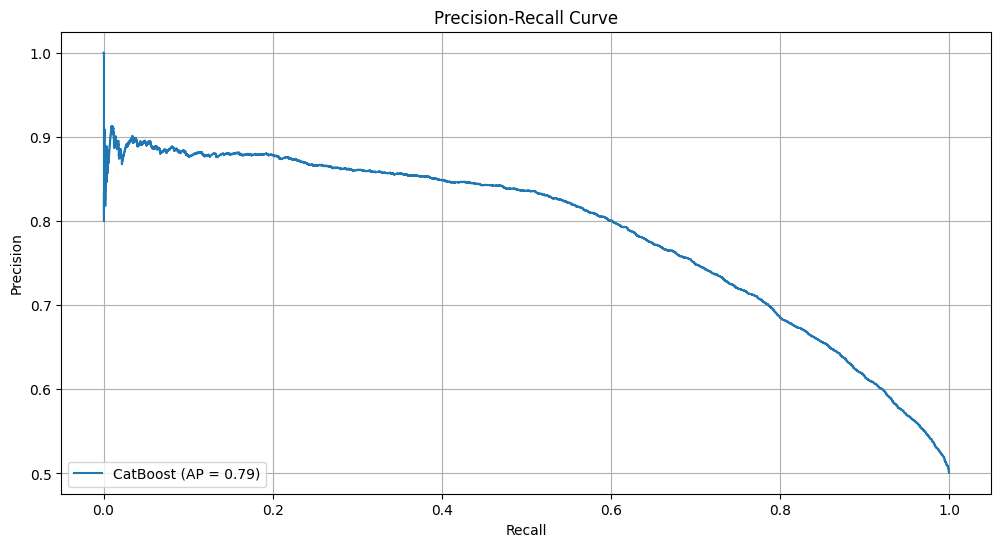

In [53]:
fig, ax = plt.subplots(figsize=(12, 6))
_ = PrecisionRecallDisplay.from_estimator(tuned_catboost, X_test, y_test, name='CatBoost', ax=ax)
_ = ax.set_title('Precision-Recall Curve')
_ = ax.set_xlabel('Recall')
_ = ax.set_ylabel('Precision')
_ = ax.grid(True)

# Confusion Matrix

Constructing confusion matrix to figure out information about `False Positives` and `False Negatives`:

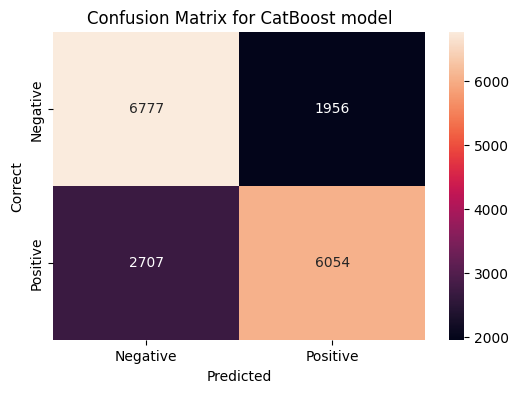

In [54]:
y_pred_test = tuned_catboost.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_test)

fig, ax = plt.subplots(figsize=(6, 4))
_ = sns.heatmap(conf_matrix, annot=True, fmt='d', ax=ax)
_ = ax.set_xlabel('Predicted')
_ = ax.xaxis.set_ticklabels(['Negative', 'Positive'])
_ = ax.set_ylabel('Correct')
_ = ax.yaxis.set_ticklabels(['Negative', 'Positive'])
_ = ax.set_title('Confusion Matrix for CatBoost model')

# Feature Importances

Having best model selected, analyzing which of the features were most important for its performance:

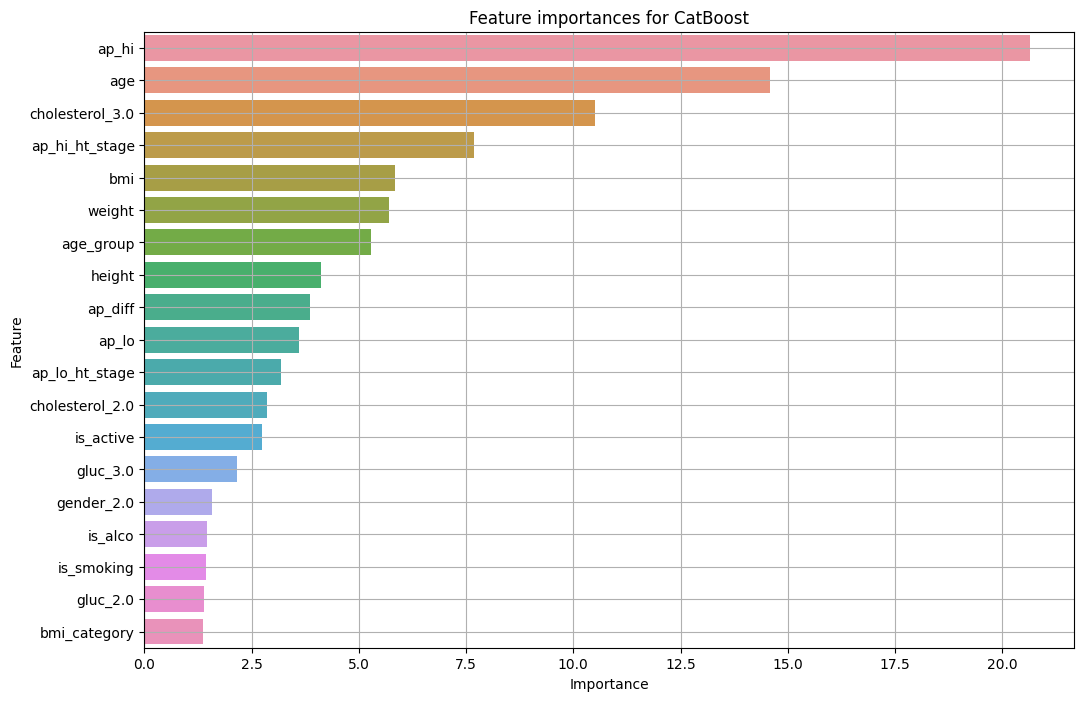

In [55]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    _ = sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], ax=ax)
    _ = ax.set_title('Feature importances for CatBoost')
    _ = ax.set_xlabel('Importance')
    _ = ax.set_ylabel('Feature')
    _ = ax.grid(True)
    
plot_feature_importance(tuned_catboost.get_feature_importance(), feature_names, 'CatBoost')

# Measuring performance on Kaggle set

Constructing a united dataset from train and test subparts:

In [56]:
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

## - Best Model (CatBoost)

Finally, running our model on Kaggle set to get a submission file:

In [57]:
final_model = CatBoostClassifier(**remove_clf_prefix(tuned_catboost_params))
final_model = final_model.fit(X_full, y_full)
y_pred_proba_kaggle = final_model.predict_proba(X_kaggle)[:, 1]

predictions_frame = pd.DataFrame({'id': kaggle_ids, 'cardio': y_pred_proba_kaggle.astype(float)}).set_index('id')
predictions_frame.to_csv('submission_best_model.csv')

## - Neural Network

Optionally, running Neural Network on Kaggle set to get submission file:

In [58]:
with torch.no_grad():
    X_kaggle_tensor = torch.FloatTensor(X_kaggle.values)
    y_valid_pred = nnet_model.forward(X_kaggle_tensor)

    predictions_frame = pd.DataFrame({'id': kaggle_ids, 'cardio': y_valid_pred.flatten()}).set_index('id')
    predictions_frame.to_csv('submission_neural_net.csv')

## - Blender Model

Also running Blender on the same Kaggle set to get its submission file:

In [59]:
def get_tuned_models():
    models = list()
    models.append(('Naive Bayes', GaussianNB(**remove_clf_prefix(tuned_bayes_params))))
    models.append(('Logistic Regression', LogisticRegression(**remove_clf_prefix(tuned_logreg_params))))
    models.append(('Decision Tree', DecisionTreeClassifier(**remove_clf_prefix(tuned_tree_params))))
    models.append(('KNN', KNeighborsClassifier(**remove_clf_prefix(tuned_knn_params))))
    models.append(('Random Forest', RandomForestClassifier(**remove_clf_prefix(tuned_forest_params))))
    return models

def fit_ensemble(models, X_train, X_val, y_train, y_val):
    X_blender = list()
    for _, model in models:
        model.fit(X_train, y_train)

        y_val_predicted_proba = model.predict_proba(X_val)
        X_blender.append(y_val_predicted_proba)

    X_blender = np.hstack(X_blender)

    blender = LogisticRegression(max_iter=5_000)
    blender.fit(X_blender, y_val)
    return blender

def predict_ensemble(models, blender, X_to_predict):
    X_blender = list()
    for _, model in models:
        y_predicted_proba = model.predict_proba(X_to_predict)
        X_blender.append(y_predicted_proba)
        
    X_blender = np.hstack(X_blender)
    return blender.predict_proba(X_blender)

models = get_tuned_models()

blender = fit_ensemble(models, X_train, X_test, y_train, y_test)

y_test_predicted_proba_blender = predict_ensemble(models, blender, X_kaggle)
y_test_predicted_proba_blender = y_test_predicted_proba_blender[:, 1]

predictions_frame = pd.DataFrame({'id': kaggle_ids, 'cardio': y_test_predicted_proba_blender.astype(float)}).set_index('id')
predictions_frame.to_csv('submission_blender.csv')

# Conclusions

Analysis of Cardiovascular Disease dataset revealed the following base factors that help to predict if some particular patient would have a CVD or not:

- `ap_hi`;
- `age`;
- `cholesterol`

In addition to these base factors, other important factors are:

- `bmi` ("Body Mass Index") that combines separate base factors `weight` and `height` (that by themselves are not meaningful and informative) into
a synthesized factor that signs if a patient has obesity or not;

- `ap_diff` (difference between systolic and diastolic blood pressure values) that informs about potential pathological conditions if difference value is less than `25%`.

Surprisingly, such factors of Health Promotion as `is_smoking` and `is_alco` showed themselves as almost redundant, but that might happen due to incorrect interpretation of the values (as EDA analysis revealed that most likely these features would not help the model to be more accurate).

Among several prediction models that were tried (including a Blender ensemble model and a Neural Netork) <u>CatBoost</u> performed most accurate in terms of ROC-AUC, resulting in `0.80006` on test set. LightGBM and Neural Network models also showed good performance on cross-validation, and most likely quality of Neural Network model could be improved by tuning number of hidden units, dropout probability values and patience of early-stopping algorithm.

Confusion matrix shows that built CatBoost model suffers more dramatically from `False Negative`s (`type II` statistical errors): `2707` wrongly classified as healthy (but really suffering from CVD) patients. As for `False Positive`s (`type I` statistical errors), they are also quite noticeable — `1956` mistakes — classified as diseased (but actually not) patients.